In [1]:
import sys 
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import torch.nn.functional as F
import scipy
import pandas as pd
import os
import glob
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('science')
pd.set_option('display.float_format', lambda x: '%.4e' % x)
# import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
from matplotlib.text import Text
import matplotlib.tri as tri

from utils import (
    load_poisson1d_kernel_dataset, load_helmholtz1d_kernel_dataset)
from utils import relative_err

In [2]:
nTrain = 500
nTest = 200
idx = 10

In [3]:
import matplotlib.tri as tri

In [18]:
def vis_1D_result(task, c=1, s=0.7, outnm=None):
    cm = 1/2.54
    f = plt.figure(figsize=(9,3.5))
    subfigs = f.subfigures(1,4).flatten()
    ax1 = subfigs[0].subplots()
    ax2 = subfigs[1].subplots()
    ax3 = subfigs[2].subplots()
    ax4 = subfigs[3].subplots()

    if task == 'poisson':
        fTrain, fTest, uTrain, uTest, X, Gref = load_poisson1d_kernel_dataset(
            '../data', nTrain, nTest)
        upath = '../results/poisson1D/oga-2048-500-relu/upred.npy'
        Gpath = '../results/poisson1D/oga-2048-500-relu/Goga.npy'
        Logpath = '../results/poisson1D/oga-2048-500-relu/log.npy'
    elif task == 'helmholtz':
        fTrain, fTest, uTrain, uTest, X, Gref = load_helmholtz1d_kernel_dataset(
            '../data', nTrain, nTest)
        upath = '../results/helmholtz1D/oga-2048-500-relu/upred.npy'
        Gpath = '../results/helmholtz1D/oga-2048-500-relu/Goga.npy'
        Logpath = '../results/helmholtz1D/oga-2048-500-relu/log.npy'
    
    Log = np.load(Logpath, allow_pickle=True).item()
    Gpred = np.load(Gpath, allow_pickle=True).item()['Gpred']
    rl2 = relative_err(Gpred, Gref)
    print(f"task : {task}")
    print("G relative L2 : {:.4e}".format(rl2))

    upred = np.load(upath, allow_pickle=True)
    rl2 = relative_err(upred, uTest)
    print(f"task : {task}")
    print("u relative L2 : {:.4e}".format(rl2))

    ns = np.array([8, 16, 32, 64, 128, 256, 512, 1024]) - 1
    On = ns ** (-1.25)
    #####################
         
    Gerr = np.abs(Gpred - Gref)
    vmin = Gref.min()
    vmax = Gref.max()

    ax1.plot(ns, Log['utest_rl2'][ns], '.-r', label='$\epsilon_u$')
    ax1.plot(ns, Log['G_rl2'][ns], '-.r', label='$\epsilon_G$')    
    ax1.plot(ns, c*On, '--k', label="$O(n^{-1.25})$")
    
    
    ax1.set_ylim([1e-4, 1])
    ax1.set_aspect(s)
    ax1.set_title('Training Dynamics')
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_xlabel("Number of Neurons")
    ax1.set_ylabel("Relative $L_2$ error")
    ax1.legend(loc='lower left', prop={'size': 8})
    label_a = Text(0.01, 0.8, '(a)', fontsize=12, transform=subfigs[0].transSubfigure, ha="left", va="top")
    subfigs[0].add_artist(label_a)


    nh = 501
    im = ax2.contourf(X[:,0].reshape(nh,nh), X[:,1].reshape(nh,nh),
        Gref.reshape(nh,nh), levels=np.linspace(vmin, vmax, 30), cmap='jet')
    ax2.set_aspect('equal')
    ax2.set_title('Reference')
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$', rotation=0)
    ax2.set_xticklabels("")
    ax2.set_yticklabels("")
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = f.colorbar(im, cax=cax, orientation='vertical')
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    label_b = Text(0.01, 0.8, '(b)', fontsize=12, transform=subfigs[1].transSubfigure, ha="left", va="top")
    subfigs[1].add_artist(label_b)

    im = ax3.contourf(X[:,0].reshape(nh,nh), X[:,1].reshape(nh,nh),
        Gpred.reshape(nh,nh), levels=np.linspace(vmin, vmax, 30), cmap='jet')
    ax3.set_aspect('equal')
    ax3.set_title('Prediction')
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$y$', rotation=0)
    ax3.set_xticklabels("")
    ax3.set_yticklabels("")
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = f.colorbar(im, cax=cax, orientation='vertical')
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    label_c = Text(0.01, 0.8, '(c)', fontsize=12, transform=subfigs[2].transSubfigure, ha="left", va="top")
    subfigs[2].add_artist(label_c)
    
    im = ax4.contourf(X[:,0].reshape(nh,nh), X[:,1].reshape(nh,nh),
        Gerr.reshape(nh,nh), levels=30, cmap='jet')
    ax4.set_aspect('equal')
    ax4.set_title('Absolute Error')
    ax4.set_xlabel('$x$')
    ax4.set_ylabel('$y$', rotation=0)
    ax4.set_xticklabels("")
    ax4.set_yticklabels("")
    divider = make_axes_locatable(ax4)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = f.colorbar(im, cax=cax, orientation='vertical')
    cbar.locator = ticker.MaxNLocator(nbins=5)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.formatter.set_useMathText(True)
    label_d = Text(0.01, 0.8, '(d)', fontsize=12, transform=subfigs[3].transSubfigure, ha="left", va="top")
    subfigs[3].add_artist(label_d)

    plt.savefig(outnm)

task : poisson
G relative L2 : 5.7327e-04
task : poisson
u relative L2 : 1.2412e-04


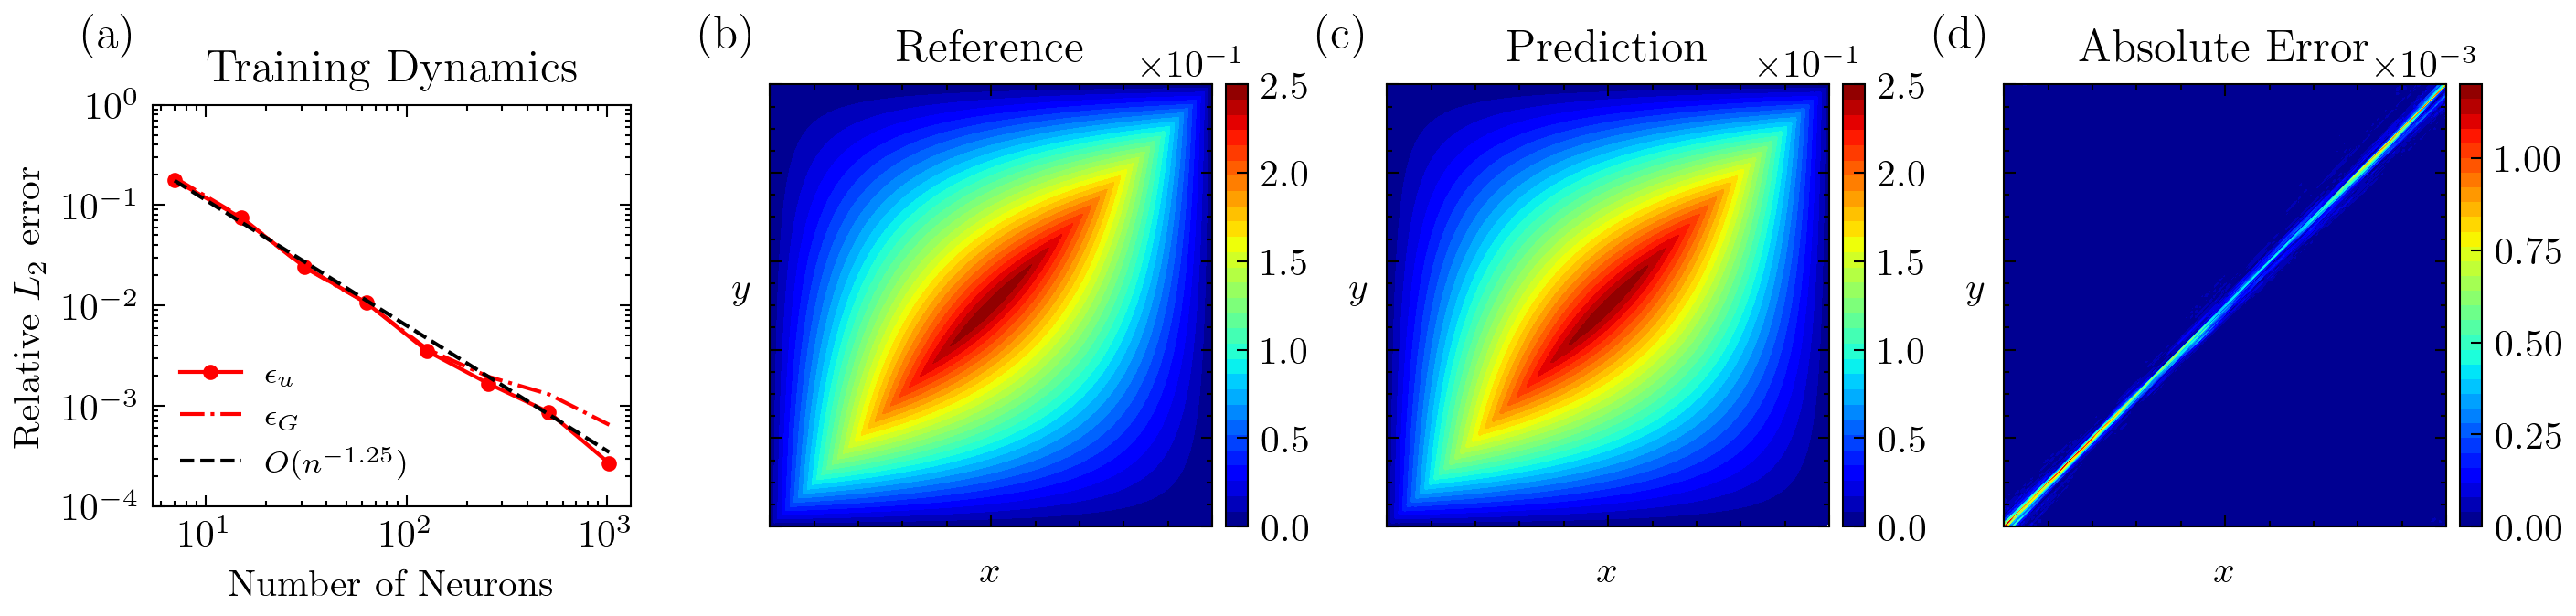

In [21]:
vis_1D_result('poisson', c=2., s=0.5, outnm='poisson1D.pdf')

task : helmholtz
G relative L2 : 2.3186e-03
task : helmholtz
u relative L2 : 1.4509e-03


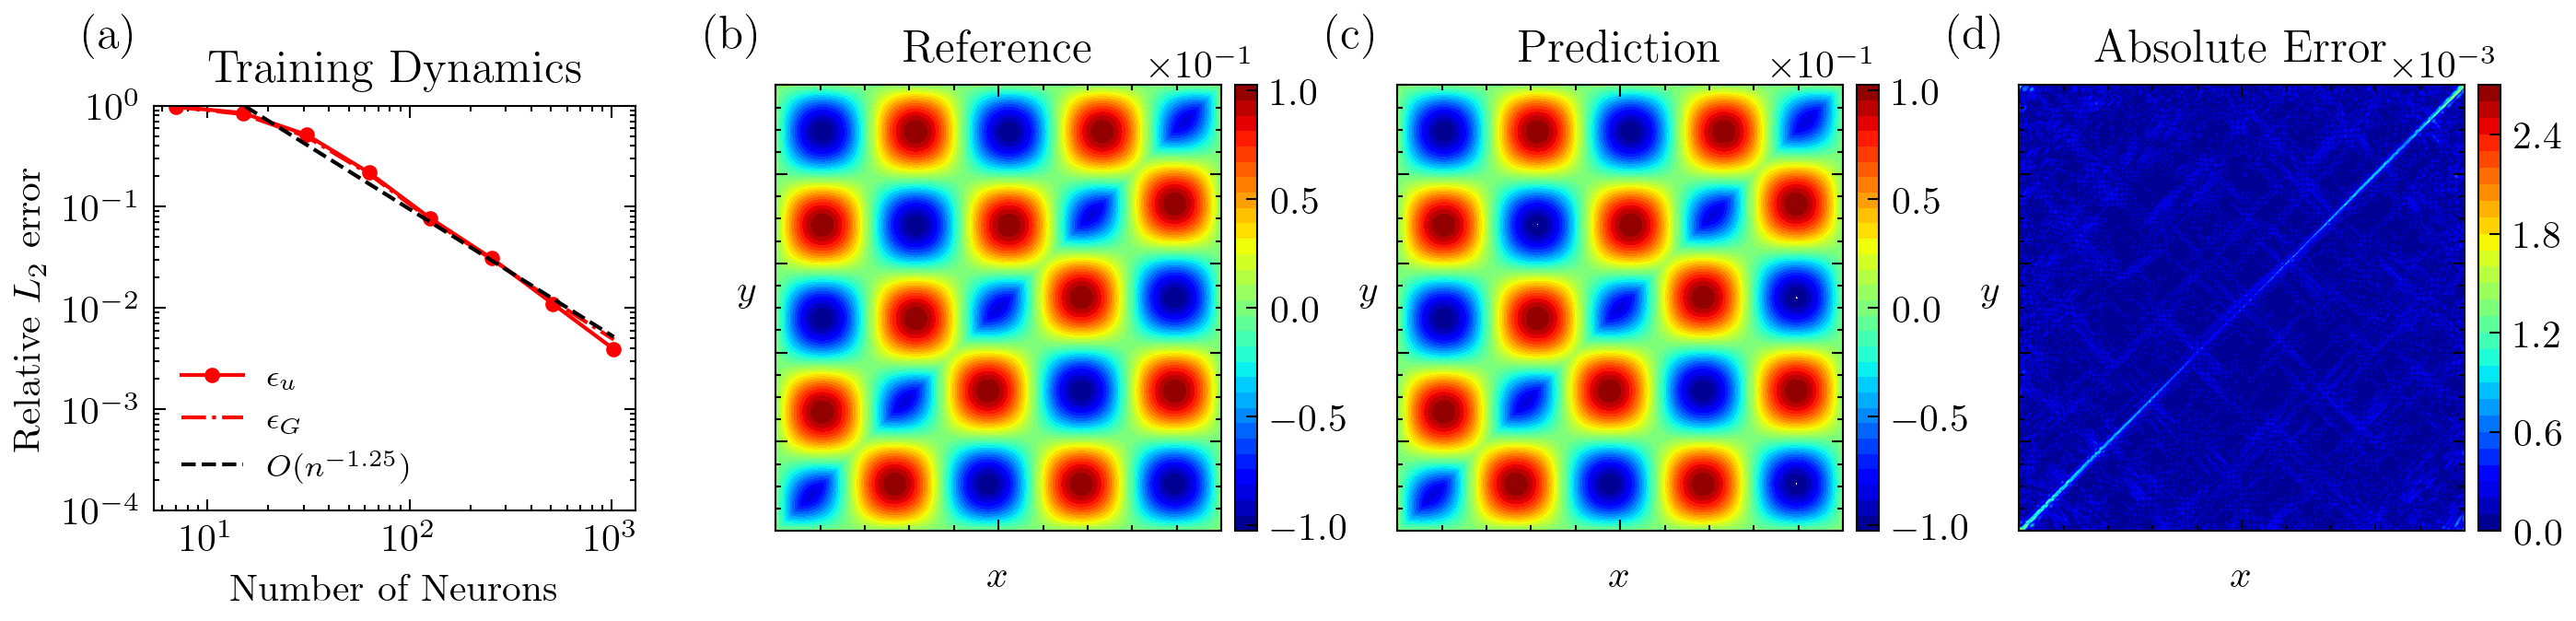

In [20]:
vis_1D_result('helmholtz', c=30, s=.5, outnm='helmholtz1D.pdf')

In [7]:
def latexlog_oga(task):
    print(task)
    Log = np.load(f'../results/{task}/oga-2048-500-relu/log.npy', allow_pickle=True).item()
    G_rl2 = Log['G_rl2']
    utest_rl2 = Log['utest_rl2']

    ord = np.arange(np.log2(4096).astype(int))
    ord = 2**ord - 1

    ord_G = np.zeros_like(ord, dtype='float')
    ord_G[1:] = np.log2(G_rl2[ord][:-1] / G_rl2[ord][1:])

    ord_test = np.zeros_like(ord, dtype='float')
    ord_test[1:] = np.log2(utest_rl2[ord][:-1] / utest_rl2[ord][1:])

    for i, idx in enumerate(ord):
        if i != 0:
            row_str = "{:d} & {:.4e} & {:.2f} & {:.4e} & {:.2f} \\\ ".format(ord[i]+1, G_rl2[idx], ord_G[i], utest_rl2[idx], ord_test[i])
            print(row_str)

In [8]:
latexlog_oga('poisson1D')

poisson1D
2 & 5.8645e-01 & 0.08 & 5.8699e-01 & 0.07 \\ 
4 & 3.8453e-01 & 0.61 & 3.8781e-01 & 0.60 \\ 
8 & 1.8760e-01 & 1.04 & 1.7726e-01 & 1.13 \\ 
16 & 7.6032e-02 & 1.30 & 7.4759e-02 & 1.25 \\ 
32 & 2.3978e-02 & 1.66 & 2.4314e-02 & 1.62 \\ 
64 & 1.0637e-02 & 1.17 & 1.0680e-02 & 1.19 \\ 
128 & 3.6735e-03 & 1.53 & 3.5092e-03 & 1.61 \\ 
256 & 1.9600e-03 & 0.91 & 1.6733e-03 & 1.07 \\ 
512 & 1.3076e-03 & 0.58 & 8.6721e-04 & 0.95 \\ 
1024 & 6.4816e-04 & 1.01 & 2.6792e-04 & 1.69 \\ 
2048 & 5.7327e-04 & 0.18 & 1.2412e-04 & 1.11 \\ 


In [9]:
latexlog_oga('helmholtz1D')

helmholtz1D
2 & 9.9615e-01 & 0.00 & 9.9582e-01 & 0.00 \\ 
4 & 9.8674e-01 & 0.01 & 9.8800e-01 & 0.01 \\ 
8 & 9.7080e-01 & 0.02 & 9.7546e-01 & 0.02 \\ 
16 & 8.2291e-01 & 0.24 & 8.4531e-01 & 0.21 \\ 
32 & 4.9235e-01 & 0.74 & 5.1435e-01 & 0.72 \\ 
64 & 2.1146e-01 & 1.22 & 2.1795e-01 & 1.24 \\ 
128 & 7.4489e-02 & 1.51 & 7.6679e-02 & 1.51 \\ 
256 & 3.0280e-02 & 1.30 & 3.0883e-02 & 1.31 \\ 
512 & 1.1773e-02 & 1.36 & 1.0999e-02 & 1.49 \\ 
1024 & 4.8710e-03 & 1.27 & 3.9165e-03 & 1.49 \\ 
2048 & 2.3186e-03 & 1.07 & 1.4509e-03 & 1.43 \\ 


In [10]:
def latexlog_compare(task):
    print(task)
    fno_url2 = np.load(f'../results/{task}/fno-500-500/log.npy', allow_pickle=True).item()['utest_rl2'].min()
    gl_url2 = np.load(f'../results/{task}/gl-10000-500/log.npy', allow_pickle=True).item()['utest_rl2'].min()
    don_url2 = np.min(np.load(f'../results/{task}/don-50000-500/log.npy', allow_pickle=True).item()['utest_rl2'])
    oga_url2 = np.load(f'../results/{task}/oga-2048-500-relu/log.npy', allow_pickle=True).item()['utest_rl2'].min()

    gl_Grl2 = np.load(f'../results/{task}/gl-10000-500/log.npy', allow_pickle=True).item()['G_rl2'].min()    
    oga_Grl2 = np.load(f'../results/{task}/oga-2048-500-relu/log.npy', allow_pickle=True).item()['G_rl2'].min()

    print('OGA & {:.4e} & {:.4e} \\\ '.format(oga_Grl2, oga_url2))
    print('GL & {:.4e} & {:.4e} \\\ '.format(gl_Grl2, gl_url2))
    print('FNO & - & {:.4e} \\\ '.format(fno_url2))
    print('DON & - & {:.4e} \\\ '.format(don_url2))
    

In [11]:
latexlog_compare('poisson1D')

poisson1D
OGA & 5.7327e-04 & 1.2411e-04 \\ 
GL & 5.8218e-03 & 5.6763e-03 \\ 
FNO & - & 3.5094e-02 \\ 
DON & - & 1.8072e-01 \\ 


In [12]:
latexlog_compare('helmholtz1D')

helmholtz1D
OGA & 2.3186e-03 & 1.4509e-03 \\ 
GL & 1.9849e-02 & 2.0166e-02 \\ 
FNO & - & 3.8912e-02 \\ 
DON & - & 2.4209e-01 \\ 
